# Waymo: min TTC distribution 

- Distribution plot
    - Total
    - Merge
    - Cross 

In [1]:
import pickle
import numpy as np
np.set_printoptions(suppress=True, precision=1) 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import scienceplots
from tqdm import tqdm
from shapely import LineString, Point
from seaborn import displot, histplot, relplot
plt.style.use(['nature'])

from scipy import stats
from waymo_devkit.conflict import Conflict

with open('./pkl/conflict_pet15s.pkl', 'rb') as file:
    conflict_list_from_pickle = pickle.load(file)
print(f"#Conflicts: {len(conflict_list_from_pickle)}")

conflict_list = list()
for c in conflict_list_from_pickle:
    conflict_list.append(
        Conflict(
            leader_id=c['leader_id'],
            leader_index=c['leader_index'],
            leader_states=c['leader_states'],
            leader_time_at_conflict=c['leader_time_at_conflict'],
            follower_id=c['follower_id'],
            follower_index=c['follower_index'],
            follower_states=c['follower_states'],
            follower_time_at_conflict=c['follower_time_at_conflict'],
            PET=c['PET'],
            conflict_type=c['conflict_type'],
            leader_is_av=c['leader_is_av'],
            follower_is_av=c['follower_is_av'],
            center=c['center'],
            radius=c['radius'],
    ))

#Conflicts: 889


In [2]:
"""
Construct a dataframe with the following columns:
- Conflict type
- Vehicle order
- PET
- minTTC
"""
conflict_cols_in_df = [
    "Conflict type",
    "Vehicle order",
    "PET",
    "minTTC"
]

# generate each rows in the dataframe
conflict_rows_in_df = list()
for index, conflict in tqdm(enumerate(conflict_list)):

    leader_type = "AV" if conflict.leader_is_av else "HV"
    follower_type = "AV" if conflict.follower_is_av else "HV" 
    conflict_type = "Cross" if conflict.conflict_type == "CROSS" else "Merge"
    conflict_rows_in_df.append([
        conflict_type,
        leader_type+"-"+follower_type,
        conflict.PET,
        conflict.minimum_TTC,
    ])
conflict_df = pd.DataFrame(conflict_rows_in_df, columns=conflict_cols_in_df)

# Post-process
PET_THRESHOLD = 10
conflict_df = conflict_df[conflict_df["PET"] <= PET_THRESHOLD]

# display info
conflict_df.info()

889it [00:00, 123068.73it/s]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 864 entries, 0 to 888
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Conflict type  864 non-null    object 
 1   Vehicle order  864 non-null    object 
 2   PET            864 non-null    float64
 3   minTTC         811 non-null    float64
dtypes: float64(2), object(2)
memory usage: 33.8+ KB


In [3]:
# Post-process: remove minTTC greater than 10s
minTTC_THRESHOLD = 10
conflict_df = conflict_df[(conflict_df["minTTC"] <= minTTC_THRESHOLD) & 
                          (conflict_df["minTTC"] >= 0)]

# display info
conflict_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 591 entries, 1 to 888
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Conflict type  591 non-null    object 
 1   Vehicle order  591 non-null    object 
 2   PET            591 non-null    float64
 3   minTTC         591 non-null    float64
dtypes: float64(2), object(2)
memory usage: 23.1+ KB


In [4]:
conflict_df["Conflict type"].value_counts()

Cross    420
Merge    171
Name: Conflict type, dtype: int64

In [5]:
conflict_df[["Conflict type", "Vehicle order"]].value_counts()

Conflict type  Vehicle order
Cross          HV-HV            216
               AV-HV            134
Merge          AV-HV            113
Cross          HV-AV             70
Merge          HV-HV             45
               HV-AV             13
dtype: int64

In [6]:
conflict_df.groupby(["Conflict type", "Vehicle order"])['minTTC'].mean()

Conflict type  Vehicle order
Cross          AV-HV            4.531782
               HV-AV            5.371154
               HV-HV            5.077929
Merge          AV-HV            5.054518
               HV-AV            6.879379
               HV-HV            6.299577
Name: minTTC, dtype: float64

In [7]:
conflict_df.groupby(["Conflict type", "Vehicle order"])['minTTC'].std()

Conflict type  Vehicle order
Cross          AV-HV            1.578383
               HV-AV            1.465959
               HV-HV            1.841649
Merge          AV-HV            1.487213
               HV-AV            1.486573
               HV-HV            1.729135
Name: minTTC, dtype: float64

In [9]:
cross_df = conflict_df[conflict_df["Conflict type"] == "Cross"]
merge_df = conflict_df[conflict_df["Conflict type"] == "Merge"]

HVHV_cross = cross_df[cross_df["Vehicle order"] == "HV-HV"]
# HVHV_cross = HVHV_cross[(HVHV_cross["minTTC"] <= 6) & (HVHV_cross["PET"] <= 6)]
AVHV_cross = cross_df[cross_df["Vehicle order"] == "AV-HV"]
# AVHV_cross = AVHV_cross[(AVHV_cross["minTTC"] <= 6) & (AVHV_cross["PET"] <= 6)]
HVAV_cross = cross_df[cross_df["Vehicle order"] == "HV-AV"]

HVHV_merge = merge_df[merge_df["Vehicle order"] == "HV-HV"]
# HVHV_merge = HVHV_merge[(HVHV_merge["minTTC"] <= 6) & (HVHV_merge["PET"] <= 6)]
AVHV_merge = merge_df[merge_df["Vehicle order"] == "AV-HV"]
# AVHV_merge = AVHV_merge[(AVHV_merge["minTTC"] <= 6) & (AVHV_merge["PET"] <= 6)]
HVAV_merge = merge_df[merge_df["Vehicle order"] == "HV-AV"]

## ANOVA

In [10]:
stats.f_oneway(HVHV_cross.minTTC, HVAV_cross.minTTC, AVHV_cross.minTTC)

F_onewayResult(statistic=6.793232983465861, pvalue=0.001249623689077311)

In [11]:
stats.f_oneway(HVHV_merge.minTTC, HVAV_merge.minTTC, AVHV_merge.minTTC)

F_onewayResult(statistic=15.702031479353334, pvalue=5.601745964653149e-07)

## T-test

In [10]:
# HVHV_cross, HVAV_cross
stats.ttest_ind(HVHV_cross.minTTC, HVAV_cross.minTTC)

Ttest_indResult(statistic=-1.2129195942999638, pvalue=0.22616847858325553)

In [11]:
# HVHV_cross, AVHV_cross
stats.ttest_ind(HVHV_cross.minTTC, AVHV_cross.minTTC)

Ttest_indResult(statistic=2.844970862287922, pvalue=0.004704411457038836)

In [12]:
# HVHV_merge, HVAV_merge
stats.ttest_ind(HVHV_merge.minTTC, HVAV_merge.minTTC)

Ttest_indResult(statistic=-1.0959881285347066, pvalue=0.27777501951832534)

In [13]:
# HVHV_merge, AVHV_merge
stats.ttest_ind(HVHV_merge.minTTC, AVHV_merge.minTTC)

Ttest_indResult(statistic=4.529920321362502, pvalue=1.1665150271972565e-05)

In [14]:
# HVAV_cross, AVHV_cross
stats.ttest_ind(HVAV_cross.minTTC, AVHV_cross.minTTC)

Ttest_indResult(statistic=3.6937299854769288, pvalue=0.0002844416056064764)

In [15]:
# HVAV_merge, AVHV_merge
stats.ttest_ind(HVAV_merge.minTTC, AVHV_merge.minTTC)

Ttest_indResult(statistic=4.189866451233432, pvalue=5.257055934752222e-05)

## Mann-Whitney U test

Cross

In [16]:
stats.mannwhitneyu(
    x=HVHV_cross.minTTC,
    y=HVAV_cross.minTTC,
    alternative='two-sided'
)

MannwhitneyuResult(statistic=6358.0, pvalue=0.04571562751813564)

In [17]:
stats.mannwhitneyu(
    x=HVHV_cross.minTTC,
    y=AVHV_cross.minTTC,
    alternative='two-sided'
)

MannwhitneyuResult(statistic=16922.0, pvalue=0.007763943565904572)

In [20]:
stats.mannwhitneyu(
    x=HVAV_cross.minTTC,
    y=AVHV_cross.minTTC,
    alternative='two-sided'
)

MannwhitneyuResult(statistic=6396.0, pvalue=2.039393973768768e-05)

Merge

In [18]:
stats.mannwhitneyu(
    x=HVHV_merge.minTTC,
    y=HVAV_merge.minTTC,
    alternative='two-sided'
) # pvalue=0.2632414365575849

MannwhitneyuResult(statistic=232.0, pvalue=0.2632414365575849)

In [19]:
stats.mannwhitneyu(
    x=HVHV_merge.minTTC,
    y=AVHV_merge.minTTC,
    alternative='two-sided'
) # pvalue=4.1476494247348134e-05

MannwhitneyuResult(statistic=3607.0, pvalue=4.1476494247348134e-05)

In [21]:
stats.mannwhitneyu(
    x=HVAV_merge.minTTC,
    y=AVHV_merge.minTTC,
    alternative='two-sided'
) # 

MannwhitneyuResult(statistic=1202.0, pvalue=0.00018012799441551996)

## Distplots

### All

<Figure size 300x300 with 0 Axes>

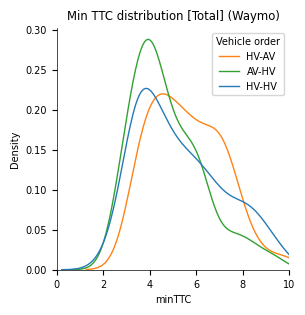

In [20]:
palette = {
    "HV-HV" : '#257ab6', 
    "AV-HV" : '#31a231',
    "HV-AV" : '#ff8214',
}

HVHV_COLOR = '#257ab6'
HVAV_COLOR = '#31a231'
AVHV_COLOR = '#ff8214'

FIGURE_WIDTH, FIGURE_HEIGHT = 3, 3
conflictType = "Total"
plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))

displot(
    data=conflict_df,
    x="minTTC", 
    hue="Vehicle order",
    hue_order=["HV-HV", "AV-HV", "HV-AV"],
    kind="kde",
    common_norm=False,
    palette=palette,
    height=FIGURE_HEIGHT,
    aspect=1.0,
    legend=False,
)

plt.xlim([0, minTTC_THRESHOLD])
# plt.ylim([0,0.15])
plt.legend(["HV-AV", "AV-HV", "HV-HV"], title="Vehicle order")
plt.title(f"Min TTC distribution [{conflictType}] (Waymo)")
# plt.savefig(f"./outputs/plots/waymo_distribution_minTTC_{conflictType}.png", dpi=300, bbox_inches="tight")
plt.show()

### Merge

<Figure size 300x300 with 0 Axes>

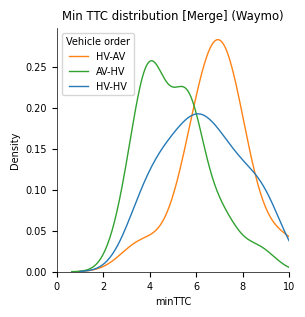

In [21]:
conflictType = "Merge"
plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))

displot(
    data=conflict_df[conflict_df["Conflict type"]==conflictType],
    x="minTTC", 
    hue="Vehicle order",
    hue_order=["HV-HV", "AV-HV", "HV-AV"],
    kind="kde",
    common_norm=False,
    palette=palette,
    height=FIGURE_HEIGHT,
    aspect=1.0,
    legend=False,
)

plt.xlim([0, minTTC_THRESHOLD])
# plt.ylim([0,0.15])
plt.legend(["HV-AV", "AV-HV", "HV-HV"], title="Vehicle order")
plt.title(f"Min TTC distribution [{conflictType}] (Waymo)")
plt.savefig(f"./outputs/plots/waymo_distribution_minTTC_{conflictType}.png", dpi=300, bbox_inches="tight")
plt.show()

### Cross

<Figure size 300x300 with 0 Axes>

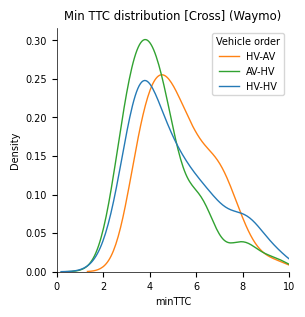

In [22]:
conflictType = "Cross"
plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))

displot(
    data=conflict_df[conflict_df["Conflict type"]==conflictType],
    x="minTTC", 
    hue="Vehicle order",
    hue_order=["HV-HV", "AV-HV", "HV-AV"],
    kind="kde",
    common_norm=False,
    palette=palette,
    height=FIGURE_HEIGHT,
    aspect=1.0,
    legend=False,
)

plt.xlim([0, minTTC_THRESHOLD])
# plt.ylim([0,0.15])
plt.legend(["HV-AV", "AV-HV", "HV-HV"], title="Vehicle order")
plt.title(f"Min TTC distribution [{conflictType}] (Waymo)")
plt.savefig(f"./outputs/plots/waymo_distribution_minTTC_{conflictType}.png", dpi=300, bbox_inches="tight")
plt.show()